# <center>Dimension reduction for the electricity data ID=1003</center>

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.datasets import (make_swiss_roll, make_s_curve)
from sklearn import datasets
import os

# import feather

In [1]:
from megaman.datasets import generate_megaman_manifold
from megaman.geometry import Geometry
from megaman.embedding import (Isomap, LocallyLinearEmbedding, LTSA, SpectralEmbedding)
from megaman.plotter import (plot_with_plotly, plot_embedding_with_plotly, 
                     plot_with_matplotlib, plot_embedding_with_matplotlib) 
from megaman.geometry.rmetric import RiemannMetric
from megaman.utils.covar_plotter import plot_cov_ellipse

# Read the electricity data in feather format

In [49]:
os.getcwd()
os.chdir(path="/Users/fche0019/git/kderm/")
np.random.seed(123)

In [4]:
# pip install feather-format

import feather

# read the smart meter data for 3 ids and 10 tow
path = 'data/spdemand_1id336tow.feather'
data = feather.read_dataframe(path)

In [5]:
data.head(10)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p192,p193,p194,p195,p196,p197,p198,p199,p200,p201
0,0.0,0.0,0.000000,0.000000,0.192508,0.327709,0.453519,0.378252,0.340095,0.334405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.140464,0.225874,0.388155,0.435609,0.356809,0.370509,0.290407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.238210,0.297175,0.404418,0.368572,0.375908,0.380093,0.287200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.113826,0.271506,0.349884,0.437520,0.357417,0.349843,0.364760,0.253428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.165439,0.278289,0.424867,0.404182,0.329715,0.354768,0.349593,0.261966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.165439,0.308875,0.423780,0.409621,0.366819,0.345644,0.334802,0.259793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.170587,0.337662,0.441113,0.397066,0.360494,0.372039,0.317396,0.251705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.146389,0.328595,0.445168,0.427115,0.368672,0.372785,0.318489,0.240465,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.161535,0.305471,0.437178,0.414975,0.336253,0.336865,0.312312,0.255254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.172723,0.256968,0.428906,0.406334,0.333699,0.318594,0.353975,0.259796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
N = len(data)
data.shape

(336, 201)

In [7]:
X = data.copy()
print(X[:1])
X['p1']
type(X)

    p1   p2   p3   p4        p5        p6        p7        p8        p9  \
0  0.0  0.0  0.0  0.0  0.192508  0.327709  0.453519  0.378252  0.340095   

        p10  ...  p192  p193  p194  p195  p196  p197  p198  p199  p200  p201  
0  0.334405  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[1 rows x 201 columns]


pandas.core.frame.DataFrame

## Colors for plotting

In [8]:
# import cmapy
# import random
# rgb_color = cmapy.color('viridis', random.randrange(0, 256), rgb_order=True)
# print(rgb_color)

In [9]:
from random import randint
color = []

# for i in range(len(X)):
#     color.append('#%06X' % randint(0, 0xFFFFFF))

# print(color)

# Dimension reduction

In [10]:
# # compute the first four principal components and plot their pairwise relationships
# X_pca = PCA(4).fit_transform(X)
# print(X_pca)
# X_pca.shape

### Initialize Geometry class

In [11]:
radius = 1
adjacency_method = 'kd_tree'
adjacency_kwds = {'radius':radius} # ignore distances above this radius
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius} # A = exp(-||x - y||/radius^2) 
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':radius} # scaling ensures convergence to Laplace-Beltrami operator

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                laplacian_method=laplacian_method, laplacian_kwds=laplacian_kwds)

### Inputing Data to Geometry

- set_data_matrix(): input an (n_observation X n_dimensions) array of data points
- set_adjacency_matrix(): input an (n_observation X n_observation) pairwise (sparse) matrix indicating neighborhoods distances. This matrix should be sparse with zero entries considered Infinite. The diagonal is considered explicitly zero when calculating an affinity matrix.
- set_affinity_matrix(): input an (n_observation X n_observation) pairwise (sparse) indicating similarity between points. High values indicate strong degree of similarity, the diagonal should take on the maximum value in its row.

In [12]:
geom.set_data_matrix(X)

### Computing geometric matrices

In [13]:
adjacency_matrix = geom.compute_adjacency_matrix()
print(adjacency_matrix)

  (0, 135)	0.6198912806024586
  (0, 38)	0.690156328118647
  (0, 39)	0.6637077766623637
  (0, 40)	0.6535310114174497
  (0, 41)	0.6485324357638712
  (0, 42)	0.5949019460042955
  (0, 43)	0.550059539444835
  (0, 44)	0.49794717480284506
  (0, 88)	0.5742613330829578
  (0, 89)	0.5722319866260552
  (0, 93)	0.46841708875797705
  (0, 136)	0.5984172605501672
  (0, 138)	0.5762072070473625
  (0, 139)	0.5578976191869564
  (0, 232)	0.5791960282704245
  (0, 234)	0.5453820748708829
  (0, 235)	0.5521258767120139
  (0, 236)	0.6101355372181629
  (0, 237)	0.553125139943381
  (0, 282)	0.6343881398403856
  (0, 284)	0.4577109822293908
  (0, 330)	0.58045814030431
  (0, 331)	0.5120735503263253
  (0, 332)	0.4255095502271572
  (0, 37)	0.7506241427120666
  :	:
  (335, 309)	0.583066712492798
  (335, 115)	0.6170279006891863
  (335, 213)	0.6865305875256164
  (335, 317)	0.6420912824281507
  (335, 73)	0.714572290251952
  (335, 308)	0.606366344974128
  (335, 165)	0.6089249780121214
  (335, 222)	0.5273909600626271
  (335

In [14]:
type(adjacency_matrix) # csr_matrix sparse matrix

scipy.sparse.csr.csr_matrix

In [15]:
adjacency_matrix.todense()
# np.save("data/adjacency_matrix_1id336tow.npy", adjacency_matrix.todense()) # error in reading in R

matrix([[0.        , 0.219312  , 0.33814413, ..., 0.30562167, 0.25297842,
         0.15449844],
        [0.219312  , 0.        , 0.17533853, ..., 0.39265777, 0.34066676,
         0.24842554],
        [0.33814413, 0.17533853, 0.        , ..., 0.46124173, 0.39865019,
         0.35306817],
        ...,
        [0.30562167, 0.39265777, 0.46124173, ..., 0.        , 0.19197091,
         0.24867399],
        [0.25297842, 0.34066676, 0.39865019, ..., 0.19197091, 0.        ,
         0.19651321],
        [0.15449844, 0.24842554, 0.35306817, ..., 0.24867399, 0.19651321,
         0.        ]])

In [16]:
aff_matrix = geom.compute_affinity_matrix()
print(aff_matrix.todense())

[[1.         0.95304062 0.89195334 ... 0.9108249  0.9380068  0.97641286]
 [0.95304062 1.         0.96972418 ... 0.85711762 0.89042728 0.94015056]
 [0.89195334 0.96972418 1.         ... 0.80836311 0.85306292 0.88279953]
 ...
 [0.9108249  0.85711762 0.80836311 ... 1.         0.96381797 0.94003445]
 [0.9380068  0.89042728 0.85306292 ... 0.96381797 1.         0.96211871]
 [0.97641286 0.94015056 0.88279953 ... 0.94003445 0.96211871 1.        ]]


In [17]:
adj_matrix = pd.DataFrame(adjacency_matrix.todense())
print(adj_matrix)
feather.write_dataframe(adj_matrix, "data/adjacency_matrix_1id336tow.feather")

          0         1         2         3         4         5         6    \
0    0.000000  0.219312  0.338144  0.427638  0.487504  0.519722  0.574172   
1    0.219312  0.000000  0.175339  0.276576  0.356690  0.385162  0.447088   
2    0.338144  0.175339  0.000000  0.152233  0.239011  0.288405  0.338728   
3    0.427638  0.276576  0.152233  0.000000  0.111815  0.189539  0.238278   
4    0.487504  0.356690  0.239011  0.111815  0.000000  0.144896  0.169190   
..        ...       ...       ...       ...       ...       ...       ...   
331  0.512074  0.595700  0.669542  0.749316  0.794578  0.832879  0.881860   
332  0.425510  0.522655  0.599381  0.684444  0.734426  0.773629  0.817472   
333  0.305622  0.392658  0.461242  0.549378  0.600970  0.644443  0.690206   
334  0.252978  0.340667  0.398650  0.486946  0.539983  0.592024  0.631963   
335  0.154498  0.248426  0.353068  0.442189  0.506478  0.551436  0.602051   

          7         8         9    ...       326       327       328  \
0  

In [18]:
# Radius selection
from scipy.sparse.csgraph import connected_components

rad1 = 0.4 # choose a small radius to start, but result in a fully connected graph
# compute an adjacency matrix with a radius
geom.adjacency_kwds = {'radius':rad1}
adjacency_matrix = geom.compute_adjacency_matrix()
# compute the corresponding affinity matrix
geom.affinity_kwds = {'radius':rad1}
affinity_matrix = geom.compute_affinity_matrix({'radius':rad1})
(number_connected_components, labels) = connected_components(affinity_matrix)
print(number_connected_components) # 1 means fully connected graph

1


In [19]:
adjacency_matrix = geom.compute_adjacency_matrix()
print(adjacency_matrix.todense())

[[0.         0.219312   0.33814413 ... 0.30562167 0.25297842 0.15449844]
 [0.219312   0.         0.17533853 ... 0.39265777 0.34066676 0.24842554]
 [0.33814413 0.17533853 0.         ... 0.         0.39865019 0.35306817]
 ...
 [0.30562167 0.39265777 0.         ... 0.         0.19197091 0.24867399]
 [0.25297842 0.34066676 0.39865019 ... 0.19197091 0.         0.19651321]
 [0.15449844 0.24842554 0.35306817 ... 0.24867399 0.19651321 0.        ]]


In [20]:
adjacency_matrix.shape

(336, 336)

### Embedding

The Isomap class functions as follows:

- An existing Geometry object can be passed to .Isomap().
 
- The .fit() method creates a Geometry object if one was not already passed and then calculates th embedding. 
    
    The number of components and eigen solver can also be passed to the .fit() function. The .fit() function for Isomap  does not return anything but it does create the attribute self.embedding_. 

- The .fit_transform() function calls the fit() function and returns the embedding. It does not allow for changing parameters.

In [21]:
# select output dimension
n_components = 2

In [26]:
# four embedding methods
isomap = Isomap(n_components=n_components, eigen_solver='arpack',geom=geom)
embed_isomap = isomap.fit_transform(X)

# lle = LocallyLinearEmbedding(n_components=n_components, eigen_solver='arpack',geom=geom)
# embed_lle = lle.fit_transform(X)

# ltsa = LTSA(n_components=n_components,eigen_solver='arpack',geom=geom)
# embed_ltsa = ltsa.fit_transform(X)

# spectral = SpectralEmbedding(n_components=3, eigen_solver='amg',geom=geom, drop_first=False) # use 3 for spectral
# embed_spectral = spectral.fit_transform(X)

/Users/fche0019/miniconda3/envs/manifold_env/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [27]:
print(embed_isomap)

[[ 7.25335283e-02 -4.64506988e-01]
 [-1.04645930e-01 -4.07341787e-01]
 [-2.03827819e-01 -2.89545454e-01]
 [-3.06526925e-01 -1.86241686e-01]
 [-3.53787587e-01 -1.22003080e-01]
 [-3.97761761e-01 -1.13577410e-01]
 [-4.57331089e-01 -5.74114330e-02]
 [-4.97124259e-01 -9.83901983e-02]
 [-3.84402726e-01 -1.04261824e-01]
 [-3.32064241e-01 -1.06065758e-01]
 [-3.20263102e-01 -6.04827043e-02]
 [-4.28812524e-01 -4.37224078e-02]
 [-4.42888610e-01 -4.45271518e-02]
 [-3.24648996e-01 -7.63776390e-02]
 [-1.24986941e-01 -9.57895597e-02]
 [ 1.15719154e-01 -1.12573559e-01]
 [ 2.63055484e-01 -1.32373422e-02]
 [ 1.51810955e-01  7.12343786e-02]
 [-1.75095274e-02  1.18751697e-01]
 [-1.61062512e-01  8.63841640e-02]
 [-2.02724534e-01  6.21073929e-02]
 [-1.84402668e-01  6.01919306e-02]
 [-1.44215971e-01  7.48223462e-02]
 [-1.25820811e-01  1.20475875e-01]
 [-1.43019037e-01  1.90698439e-01]
 [-1.17852744e-01  2.48113573e-01]
 [-8.01172372e-02  2.41643183e-01]
 [-4.75525949e-02  2.33278733e-01]
 [-7.04411667e-02  1

## Save embedding output as .npy or dataframe as .feather

In [28]:
emb_isomap = pd.DataFrame(embed_isomap)
emb_lle = pd.DataFrame(embed_lle)
emb_ltsa = pd.DataFrame(embed_ltsa)
emb_spectral = pd.DataFrame(embed_spectral)
feather.write_dataframe(emb_isomap, "data/embedding_isomap_1id336tow.feather")
feather.write_dataframe(emb_lle, "data/embedding_lle_1id336tow.feather")
feather.write_dataframe(emb_ltsa, "data/embedding_ltsa_1id336tow.feather")
feather.write_dataframe(emb_spectral, "data/embedding_spectral_1id336tow.feather")

In [29]:
np.save("data/embedding_isomap_1id336tow.npy", emb_isomap)
np.save("data/embedding_lle_1id336tow.npy", embed_lle)
np.save("data/embedding_ltsa_1id336tow.npy", embed_ltsa)
np.save("data/embedding_spectral_1id336tow.npy", embed_spectral)

### Embedding 2-D plots

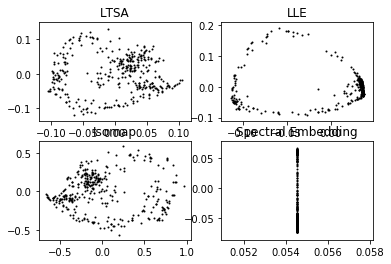

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2)
color = "black"
axes[0, 0].scatter(embed_ltsa[:, 0], embed_ltsa[:, 1], s=1, c=color)
axes[0, 0].set_title('LTSA')
axes[0, 1].scatter(embed_lle[:, 0], embed_lle[:, 1], s=1, c=color)
axes[0, 1].set_title('LLE')
axes[1, 0].scatter(embed_isomap[:, 0], embed_isomap[:, 1], s=1, c=color)
axes[1, 0].set_title('Isomap')
axes[1, 1].scatter(embed_spectral[:, 0], embed_spectral[:, 1], s=1, c=color)
axes[1, 1].set_title('Spectral Embedding')
plt.show()

# Riemannian metric

To compute a R. Metric you will need an embedding and a Laplacian.

If you plan to estimate the Riemannian Metric then when you compute the Laplacian for best results you should use **laplacian_method = 'geometric'** and set the keyword parameter 'scaling_epps' to the 'radius' that was used in the affinity method.

In [32]:
geom.laplacian_method = 'geometric'
geom.laplacian_kwds = {'scaling_epps':rad1} # scaling ensures convergence to Laplace-Beltrami operator
laplacian_matrix = geom.compute_laplacian_matrix()

**The `H` matrix is the inverse of the Riemmanian matrix `R`**, both matrix has the dimension of N\*d\*d, where `N` is the `len(X)` and `d` is the embedding dimension. 

In [33]:
# Estimate Riemannian metric for all four methods
# from megaman.geometry.rmetric import RiemannMetric

rmetric_spectral = RiemannMetric(embed_spectral, geom.laplacian_matrix)
H_spectral = rmetric_spectral.get_dual_rmetric()

rmetric_ltsa = RiemannMetric(embed_ltsa, geom.laplacian_matrix)
H_ltsa = rmetric_ltsa.get_dual_rmetric()

rmetric_lle = RiemannMetric(embed_lle, geom.laplacian_matrix)
H_lle = rmetric_lle.get_dual_rmetric()

rmetric_isomap = RiemannMetric(embed_isomap, geom.laplacian_matrix)
H_isomap = rmetric_isomap.get_dual_rmetric()

In [34]:
# The dimension of the array is N*d*d, where d is the embedding dimension
print(rmetric_isomap.get_mdimG())

2


In [35]:
print(H_isomap[:5, :]) # N*2*2 array

[[[ 0.37657276 -0.00438684]
  [-0.00438684  0.1747971 ]]

 [[ 0.52007754 -0.11369637]
  [-0.11369637  0.29993027]]

 [[ 0.48904899 -0.16537277]
  [-0.16537277  0.45455754]]

 [[ 0.37679447 -0.03845628]
  [-0.03845628  0.44216369]]

 [[ 0.36131051  0.04819333]
  [ 0.04819333  0.36827898]]]


In [36]:
R_isomap = rmetric_isomap.get_rmetric() # N*2*2 array
R_isomap[:3, :]

array([[[2.65630592, 0.06666465],
        [0.06666465, 5.72259192]],

       [[2.09653286, 0.79474529],
        [0.79474529, 3.63537714]],

       [[2.33162923, 0.84827101],
        [0.84827101, 2.50855132]]])

In [37]:
H_inverse = np.linalg.inv(H_isomap)
print(H_inverse[:3, :])
np.array_equal(H_inverse, R_isomap)

[[[2.65630592 0.06666465]
  [0.06666465 5.72259192]]

 [[2.09653286 0.79474529]
  [0.79474529 3.63537714]]

 [[2.33162923 0.84827101]
  [0.84827101 2.50855132]]]


False

## Export the inverse of Riemannian matrix, H matrix

The Numpy binary .npy can then be read in R using the `reticulate` package. 

In [38]:
np.save("data/hmatrix_isomap_1id336tow.npy", H_isomap)
np.save("data/hmatrix_lle_1id336tow.npy", H_lle)
np.save("data/hmatrix_ltsa_1id336tow.npy", H_ltsa)
np.save("data/hmatrix_spectral_1id336tow.npy", H_spectral)

In [39]:
R_isomap = rmetric_isomap.get_rmetric()
np.save("data/rmatrix_isomap_1id336tow.npy", R_isomap)

## Plot distortion

Use the *cover_plotter* module included in megaman to plot a subset of the points as ellipses representing the distortion

In [46]:
# from megaman.utils.covar_plotter import plot_cov_ellipse
n_plot = 100 # number of ellipse to be plotted
rng = np.random.RandomState(8675309)
sample_points = rng.choice(range(N), n_plot, replace = False)

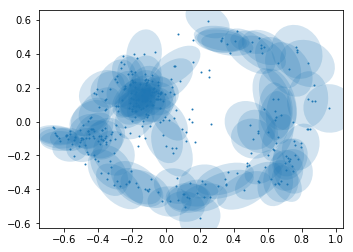

In [48]:
# Isomap
f, ax = plt.subplots()
ax.scatter(embed_isomap[:, 0], embed_isomap[:, 1], s = 1)
ax.set_aspect('equal') # if an ellipse is a circle no distortion occured. 
for i in range(n_plot):
    ii = sample_points[i]
    cov = H_isomap[ii, :, :]
    plot_cov_ellipse(cov*0.01, embed_isomap[ii, :] ,ax=ax, edgecolor='none', alpha = 0.2) # tune cov*0.1 to change the ellipse size
plt.show()

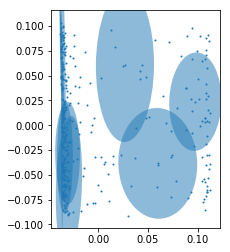

In [95]:
# LLE embedding
f, ax = plt.subplots()
ax.scatter(embed_lle[:, 0], embed_lle[:, 1], s = 1)
ax.set_aspect('equal') # if an ellipse is a circle no distortion occured. 
for i in range(n_plot):
    ii = sample_points[i]
    cov = H_lle[ii, :, :]
    plot_cov_ellipse(cov*0.1, embed_lle[ii,:] ,ax=ax, edgecolor='none', alpha = 0.5)
plt.show()

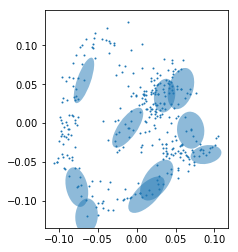

In [96]:
# LTSA embedding
f, ax = plt.subplots()
ax.scatter(embed_ltsa[:, 0], embed_ltsa[:, 1], s = 1)
ax.set_aspect('equal') # if an ellipse is a circle no distortion occured. 
for i in range(n_plot):
    ii = sample_points[i]
    cov = H_ltsa[ii, :, :]
    plot_cov_ellipse(cov*0.05, embed_ltsa[ii,:] ,ax=ax, edgecolor='none', alpha = 0.5)
plt.show()

TypeError: return arrays must be of ArrayType

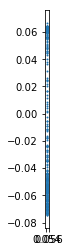

In [97]:
# Spectral embedding
f, ax = plt.subplots()
ax.scatter(embed_spectral[:, 0], embed_spectral[:, 1], s = 1)
ax.set_aspect('equal') # if an ellipse is a circle no distortion occured. 
for i in range(n_plot):
    ii = sample_points[i]
    cov = H_spectral[ii, :, :]
    plot_cov_ellipse(cov*0.01, embed_spectral[ii,:] ,ax=ax, edgecolor='none', alpha = 0.5)
plt.show()